# important note!!!
## For some reasons, some markdowns do not show properly in Github. Please download the jupyter-notebook and run it locally.

In [1]:
import glob
import numpy as np
from numpy import savetxt
from numpy import loadtxt
import tifffile as tif
from scipy import signal
import cv2
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

# Part 0: parameter define

In [48]:
img_path = '../images/'
num_basis = 512
labda = 0.15
patch_size = 5
num_patches = 100000
upscale = 2
threshold = 10

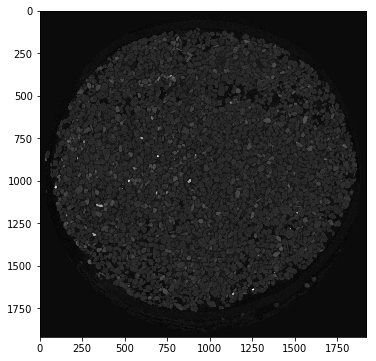

In [84]:
# image visualization
sample1 = tif.imread(img_path+'sample1.tif')
plt.figure(figsize=(6,6))
plt.imshow(sample1, plt.cm.gray)
plt.show()

# Part 1: Feature Engineering
<font size = "4">Like all machine learning practice, we first generate raw features and ensemble them into a data matrix.
    
    
- The merit of this method is that, we do not need too much training data to train the model and one perfect appliication is to replicate similar, regular pattern for a single image. For this demo, we will focus on super-resolute an X-ray tomography image on granular material. In some engineering study, it is important to understand how does the shape of individual particles influence the mechanical behavior in macroscopic scale. There are very nice tools to construct 3D avatars from images with high fidelity, but the first question is that can we prettify the image on the first hand such that the reconstructed particles look as close as the original one.

- The smallest data unit is image patch with size $5 \times 5$, which are randomly chosen from a high resolution image and the same position of its low resolution counterpart. The low resolution image was derived from the high resolution one, first downgrade it via interpolation and upgrade it back to make sure it has the same dimension as the high resolution one has. We hope to extract useful information as much as possible, in this and most applications, researchers are most concerned about the high resolution components, which correpsonds to the edges and boundaries in an image. As some high frequency information were lost in low resolution image, we applied four common kernel (first and second order gradient in both horizontal and vertical direction) to extract high frequency components.

- We ensemble $100000$ patches from a sets of images. The number of patches chosen from each image was determined by its size. For this demo, all our sample images has the same size.

</font>


In [39]:
def normalize_image(img, L):
    """
    Normalize image to be in the range [0, 255], type: np.uint8
    """
    _min, _max = img.min(), img.max()
    img = ((img-_min)/(_max-_min) * (L-1)).astype(np.uint8)
    return img

def sample_patches(img, patch_size, num_copies, upscale):
    """
    generate features for one image
    Input:
        img, np.ndarray, input high resolution image
        patch_size: image subpatch as one sample of size patch_size, i.e, 5x5
        num_copies: number of patches taken from this image
        upscale: scale of upgrade, i.e, 2
    Output:
        x_high, x_low: both high resolution and low resolution features for an image
    """
    high_resolution_img = img
    high_resolution_img = high_resolution_img.astype(float)
    m, n = high_resolution_img.shape
    
    # generate low resolution counterparts
    # first degrade original high resolution image with bicubic interpolation
    # then, upgrade the resulted image back, using bicubic interpolation as well
    low_resolution_img  = cv2.resize(\
        high_resolution_img, (m//upscale, n//upscale),interpolation=cv2.INTER_CUBIC)
    low_resolution_img  = cv2.resize(\
        low_resolution_img, (m, n), interpolation=cv2.INTER_CUBIC)
    low_resolution_img = low_resolution_img.astype(float)

    x = np.arange(m-2*patch_size)+patch_size
    y = np.arange(n-2*patch_size)+patch_size
    np.random.shuffle(x)
    np.random.shuffle(y)

    X, Y = np.meshgrid(x,y)
    xrow, ycol = X.reshape(-1), Y.reshape(-1)
    if num_copies < len(xrow):
        xrow = xrow[:num_copies]
        ycol = ycol[:num_copies]
    else:
        num_copies = len(xrow)

    # initialize output, vectorize image patch.
    # one feature for each high resolution image patch
    # four features for each low resolution image patch
    x_high = np.zeros((patch_size**2, num_copies))
    x_low  = np.zeros((4*patch_size**2, num_copies))

    # compute the first and second order gradients to extract features
    hf1 = np.array([-1,0,1]).reshape(1,-1)
    vf1 = hf1.T
    hf2 = np.array([1,0,-2,0,1]).reshape(1,-1)
    vf2 = hf2.T
    
    
    ###### TODO: part(a) ######
    # get low_resolution_img features using four Kernels above through convolution#
    low_resolution_feature1 = signal.convolve2d(low_resolution_img, hf1, 'same')
    low_resolution_feature2 = signal.convolve2d(low_resolution_img, vf1, 'same')
    low_resolution_feature3 = signal.convolve2d(low_resolution_img, hf2, 'same')
    low_resolution_feature4 = signal.convolve2d(low_resolution_img, vf2, 'same')
    ###### TODO: part(a) ######
    

    # collect patches from sample
    for i in np.arange(num_copies):
        row, col = xrow[i], ycol[i]
        Hpatch  = high_resolution_img[row:row+patch_size, col:col+patch_size].reshape(-1)
        Lpatch1 = low_resolution_feature1[row:row+patch_size, col:col+patch_size].reshape(-1)
        Lpatch2 = low_resolution_feature2[row:row+patch_size, col:col+patch_size].reshape(-1)
        Lpatch3 = low_resolution_feature3[row:row+patch_size, col:col+patch_size].reshape(-1)
        Lpatch4 = low_resolution_feature4[row:row+patch_size, col:col+patch_size].reshape(-1)
        Lpatch  = np.concatenate([Lpatch1,Lpatch2,Lpatch3,Lpatch4],axis=0)
        x_high[:,i] = Hpatch-np.mean(Hpatch)
        x_low[:,i]  = Lpatch

    return x_high, x_low

In [45]:
def rnd_smp_patch(img_path, type_extension, patch_size, num_patches, upscale):
    """
    Ensembel overall raw feature X_high and X_low for all images in img_path
    Input:
        img_path: string
        type_extension: string, file extension, i.e., .tif
        patch_size: image subpatch as one sample of size patch_size, i.e, 5x5
        num_patches: total number of copies from all images, 
            i.e, suppose 100 patches from 10 images, then num_patches = 1000.
        upscale: scale of upgrade, i.e, 2
    Output:
        X_high, X_low: both high resolution and low resolution features for all images in img_path
    """
    # get all training images name
    img_list = glob.glob(img_path+type_extension) # type_extension = '*.tif'
    # get total number of images being considered
    img_num = len(img_list)
    # initialize number of copies for each image
    # depends on its size
    num_copies_img = np.zeros(img_num)

    # read images and determine number of copies for each image
    # this number is proportional to total number of patches
    ###### TODO: part(b) ######
    #Fill num_copies_img such that each image was sampled proportional to it size#
    for i in np.arange(img_num):
        img = tif.imread(img_list[i])
        num_copies_img[i] = np.prod(img.shape)
    num_copies_img = np.floor(num_copies_img*num_patches/np.sum(num_copies_img)).astype(np.int)
    ###### TODO: part(b) ######

    # initialize output
    X_high = []
    X_low  = []

    for i in np.arange(img_num):
        num_copies = num_copies_img[i]
        img = tif.imread(img_list[i])
        # normalize image in the range of [0, 255], type: np.uint8
        img = normalize_image(img, 256)
        x_high, x_low = sample_patches(img, patch_size, num_copies, upscale)
        X_high.append(x_high)
        X_low.append(x_low)

    # assemble a numpy ndarray
    X_high = np.concatenate(X_high, axis=1)
    X_low  = np.concatenate(X_low, axis=1)

    # save data
    # save_path = '../Training/rnd_patches'+str(patch_size)+'_'+str(upscale)+'_'
    # savetxt(save_path+'X_high.csv', X_high, delimiter=' ')
    # savetxt(save_path+'X_low.csv', X_low, delimiter=' ')

    return X_high, X_low

In [46]:
def patch_pruning(X_high, X_low, threshold):
    """
    Some patchs trivial and do not contain too much information, delete them according to threshold.
    There is no code work for this part.
    This function provides data pre-processing tools.
    """
    vars = np.var(X_high, axis=0)
    idx  = vars > threshold
    X_high = X_high[:,idx]
    X_low  = X_low[:,idx]

    high_dim = X_high.shape[0]
    low_dim  = X_low.shape[0]

    # should pre-normalize X_high and X_low
    high_norm  = np.sqrt(np.sum(X_high**2, axis=0))
    low_norm   = np.sqrt(np.sum(X_low**2, axis=0))
    nontrivial = np.intersect1d(np.where(high_norm != 0)[0], np.where(low_norm != 0)[0])

    X_high = X_high[:,nontrivial]
    X_low  = X_low[:,nontrivial]

    X_high = X_high/np.sqrt(np.sum(X_high**2, axis=0))
    X_low  = X_low/np.sqrt(np.sum(X_low**2, axis=0))

    # joint learning of the dictionary
    X = np.concatenate([np.sqrt(high_dim)*X_high, np.sqrt(low_dim)*X_low], axis=0)
    X_norm = np.sqrt(np.sum(X**2, axis=0))
    X = X[:,X_norm > 1e-5]
    X = X/np.sqrt(np.sum(X**2, axis=0))
    
    # save data
    save_path = '../Training/rnd_patches'+str(patch_size)+'_'+str(upscale)+'_'
    savetxt(save_path+'X.csv', X, delimiter=' ')

    return X

In [49]:
# generate raw X_high and X_low from images in img_path
X_high, X_low = rnd_smp_patch(img_path, '*.tif', patch_size, num_patches, upscale)

# prune patches wiith small variances
# threshold chosen based on the training data
X = patch_pruning(X_high, X_low, threshold)

In [50]:
# print the dimension of final data size
# first 100 rows are low resolution image features, for a low resolution image, there are four features
# last 25 rows are high resolution image feature
# We initialize 100000 samples and only 34735 samples are left, which makes sense. 
# as many patches do not contain too much information, i.e, variances are small
X.shape
# ANS: (125, 34735)

(125, 34735)

# Part 2: Train Sparse Representation Dictionary 
<font size="4">
This learning-based algorithm is a sparse coding problem to explore sparse representations of the signals with respect to an overcomplete dictionary $\textbf{D}$. A particular formulation to learn a compact dictionary while guarantees sparse representation is given: \begin{equation*} \label{eq:pareto mle2} \begin{aligned} \textbf{D} = \arg & \min_{\textbf{D}, Z}. ||X-\textbf{D}\textbf{Z}||_2^2 + \lambda || \textbf{Z}||_1 \\ & s.t. \ ||D_i||_2^2 \leq 1, i=1,2,\cdots,K \end{aligned}\end{equation*} where the $l_1$ norm $|| \textbf{Z}||_1$ is to enforce sparsity, and the $l_2$ norm constraints on the columns of $\textbf{D}$ remove the scaling ambiguity (otherwise, the cost can always be reduce by dividing  $\textbf{Z}$ by $c>1$ and multiplying $\textbf{D}$ by $c>1$). This constrained least square problem is the second convex optimization problem we are going to solve. Note that this is not convex if both $\textbf{D}$ and  $\textbf{Z}$ are free to vary, but is convex in one of them with the other fixed. The optimization performs in an iteratively manner over $\textbf{Z}$ and $\textbf{D}$:
    
1. Initialize $\textbf{D}$ with a Gaussian random matrix, with each column unit normalized.

2. Fix $\textbf{D}$, update $Z$ by $$Z = \arg \min_{Z} ||X-\textbf{D}Z||_2^2+\lambda ||Z||_1$$ which can be solved efficiently through linear programming.

3. Fix $Z$, update $\textbf{D}$ by $$D = \arg \min_{\textbf{D}, Z} ||X-\textbf{D}\textbf{Z}||_2^2 \ s.t. \ ||D_i||_2^2 \leq 1, i=1,2,\cdots,K $$ 
which is quadratically constrained quadratic programming that could be solved in many optimization packages, providing objective function, gradient and Hessian.

4. Iterate between (2) and (3) until converge.
</font>

## $L_1$-Regularized Least Squares
<font size = "4">
The feature-sign search algorithm is presented here, which is aimed to solve the following equivalent optimization problem: $$\min_{x} ||y-Ax||^2 + \gamma ||x||_1$$ If we know the signs (positive, zero or negative) of the $x_i$ at the optimal value, we can replace each of the term $||x_i||_1$ with either $x_i$ if ($x_i > 0$), $-x_i$ (if $x_i < 0$), or 0 (if $x_i = 0$). Consider only nonzero coefficients, this reduces to a standard, unconstrained quadratic optimization problem, which can be solved analytically and efficiently. The presented algorithm therefore attempts to search or guess iteratively the signs of the coefficients $x_i$ 
    
This is nothing but LASSO regularizatiion, we have discussed it during the lecture, but unlike ridge regression, we did not actually dip into how to solve it. Here we provides a popular algorithm for this problem. For each training sample $X[:,i]$, we can apply this algorithm to solve its sparse code $Z[:,i]$ because each column can be opimized separately.

The detail of the algorithm is described in the following paper:

*'Efficient Sparse Coding Algorithms', Honglak Lee, Alexis Battle, Rajat Raina, Andrew Y. Ng, Advances in Neural Information Processing Systems (NIPS) 19, 2007*
</font>

In [51]:
def L1_FeatureSign(gamma, A, b):
    """
    The detail of the algorithm is described in the following paper:
    'Efficient Sparse Coding Algorithms', Honglak Lee, Alexis Battle, Rajat Raina, Andrew Y. Ng,
    Advances in Neural Information Processing Systems (NIPS) 19, 2007

    minimize 0.5*x.T @ A @ x + b.T @ x + gamma * |x|
    """
    A = A.astype(float)
    b = b.astype(float)
    x = np.zeros(A.shape[0])
    eps = 1e-9
    grad = A @ x + b
    ii = np.argmax(np.abs(grad*(x==0)))

    while True:
        if grad[ii] > gamma+eps:
            x[ii] = (gamma-grad[ii])/A[ii,ii]
        elif grad[ii] < -gamma-eps:
            x[ii] = (-gamma-grad[ii])/A[ii,ii]
        else:
            if np.all(x==0):
                break

        while True:
            # consider active set
            activated = x != 0
            AA = A[activated,:][:,activated]
            bb = b[activated]
            xx = x[activated]
            # new b based on unchanged sign
            # Ax + b + gamma * sign(x) = 0
            b_new = -gamma*np.sign(xx)-bb
            # analytical solution
            x_new = np.linalg.inv(AA)@b_new
            idx   = x_new != 0
            cost_new  = (b_new[idx]/2 + bb[idx]).T @ x_new[idx] + \
                                gamma*np.sum(np.abs(x_new[idx]))
            change_signs = np.where(xx*x_new <= 0)[0]
            # if no sign change, x_new is optimum since it's analytical solution
            if len(change_signs) == 0:
                x[activated] = x_new
                loss         = cost_new
                break
            # find the best interpolation solution x_inter between x_new and xx
            # x_inter is improved compared with xx, because of convexity
            x_min    = x_new
            cost_min = cost_new
            d        = x_new-xx
            t        = d/xx
            for pos in change_signs:
                x_inter = xx - d/t[pos] # interpolating at pos-th point
                x_inter[pos] = 0        # make sure it is zero
                idx = x_inter != 0
                # cost of x_inter
                cost_temp = (AA[idx,:][:,idx]@x_inter[idx]/2+bb[idx]).T@x_inter[idx] + \
                        gamma*np.sum(np.abs(x_inter[idx]))
                if cost_temp < cost_min:
                    x_min = x_inter
                    cost_min = cost_temp
            # update x and loss
            x[activated] = x_min
            loss         = cost_min

        grad  = A @ x + b
        ii    = np.argmax(np.abs(grad*(x==0)))
        max_x = np.abs(grad[ii])
        if max_x <= gamma+eps:
            break

    return x

In [53]:
def L1_FeatureSign_Setup(X, D, labda):
    """
    minimize ||X[:,j] - D*Z[:,j]||_2^2 + 2*sigma^2*beta |Z[:,j]|_1
    2*sigma^2*beta = labda
    since z = Z[:,j] could be separately optimized
    """
    M, N = X.shape
    K = D.shape[1]
    Z = np.zeros((K,N))
    A = D.T @ D
    for i in np.arange(N):
        b = -D.T @ X[:,i]
        ###### TODO: part(c) ######
        #Use the feature sign algorithm to solve sparse code for each training data#
        #This is nothing but LASSO regularization, feel free to use existinig library#
        Z[:,i] = L1_FeatureSign(labda, A, b)
        ###### TODO: part(c) ######
    return Z

## Solve Constrained Least Squares with Lagrange Dual
<font size = "4">
    After $Z$ is solved (each column of $Z$ is the solution of a $L_1$ regularized least squares), a method is presented here for solving optimization problem over $D$, this will be useful to alternatively find out compact dictionary with sparse representation $Z$. Following problem will be discussed in this section: $$ \min_{D} ||X-DZ||_F^2 \\ s.t. \sum_{i=1}^k D_{i,j}^2 \leq c, \forall j = 1, \cdots, n. $$ Or equivalently consider the Lagrangian: $$\mathcal{L}(D, {\lambda}) = \text{trace}((X-DZ)^T(X-DZ)) + \sum_{j=1}^n {\lambda}_j (\sum_{i=1}^k D_{i,j}^2 - c)$$ where each ${\lambda}_j \geq 0$ is a dual variable. Minimizing over $D$ analytically, we obtain the Lagrange dual: $$\mathcal{D}({\lambda}) = \min_{D} \mathcal{L}(D, {\lambda})= \text{trace}(X^T -X Z^T (ZZ^T + \Lambda)^{-1} (XZ^T)^T - c\Lambda)$$ where $\Lambda = \text{diag}({\lambda})$. The gradient and Hessian of $\mathcal{D}({\lambda})$ are computed as follows: $$\frac{\mathcal{D}({\lambda})}{\partial \lambda_i} = ||XZ^T(ZZ^T + \Lambda)^{-1} e_i||^2 - c$$ $$\frac{\partial^2 \mathcal{D}({\lambda})}{\partial \lambda_i \partial \lambda_j} = -2 (ZZ^T + \Lambda)^{-1} (XZ^T)^T XZ^T (ZZ^T + \Lambda)^{-1})_{i,j} ((ZZ^T + \Lambda)^{-1})_{i,j}$$ where $e_i \in \mathbb{R}^n$ is the $i$-th unit vector. Now, the Lagrange dual problem could be optimized using Newton's method or conjugate gradient. After maximizing $\mathcal{D}({\lambda})$, the optimum dictionary $D$ is obtained: $$D^T = (ZZ^T + \Lambda)^{-1}(XZ^T)^T$$.
    
For this part try to implement the objective function, gradient and Hessian.
    </font>

In [62]:
def L2_Lagrange_Dual(X, Z, c=1):
    M, N = X.shape
    K = Z.shape[0]

    ZZt = Z @ Z.T
    XZt = X @ Z.T

    # arbitrary initialization dual_lambda as Gaussian
    dual_lambda = 10*np.abs(np.random.rand(K))
    trXXt = np.sum(X**2)
    options = {'disp':True, 'maxiter': 100}
    
    # those three are good, if warning says Desired error not necessarily achieved due to precision loss.
    # try another method
    res = minimize(object_func, dual_lambda, args=(ZZt, XZt, X, c, trXXt), jac = gradient_func, method='CG', options=options)
    #res = minimize(object_func, dual_lambda, args=(ZZt, XZt, X, c, trXXt), jac = gradient_func, hess = hessian_func, method='trust-ncg', options=options)
    #res = minimize(object_func, dual_lambda, args=(ZZt, XZt, X, c, trXXt), jac = gradient_func, hess = hessian_func, method='Newton-CG', options=options)
    dual_lambda = res.x
    ###### TODO: part(d) ######
    #After getting oprimum dual_lambda, solve D analytically#
    Dt = np.linalg.inv(ZZt+np.diag(dual_lambda)) @ XZt.T
    D  = Dt.T
    ###### TODO: part(d) ######
    return D

def object_func(dual_lambda, ZZt, XZt, X, c, trXXt):
    # objective function at given dual_lambda
    L = XZt.shape[0]
    M = len(dual_lambda)
    ZZt_inv = np.linalg.inv(ZZt+np.diag(dual_lambda))
    ###### TODO: part(e) ######
    #create objective function f#
    if L > M:
        f = -np.trace(ZZt_inv @ (XZt.T @ XZt)) + trXXt - c*np.sum(dual_lambda)
    else:
        f = -np.trace(XZt @ ZZt_inv @ XZt.T) + trXXt - c*np.sum(dual_lambda)
    ###### TODO: part(e) ######
    return -f

def gradient_func(dual_lambda, ZZt, XZt, X, c, trXXt):
    L = XZt.shape[0]
    M = len(dual_lambda)
    ZZt_inv = np.linalg.inv(ZZt+np.diag(dual_lambda))
    ###### TODO: part(f) ######
    #create gradient of the function at given dual_lambda
    g = np.zeros((M,1))
    temp = XZt @ ZZt_inv
    g = np.sum(temp**2, axis=0)-c
    ###### TODO: part(f) ######
    return -g

def hessian_func(dual_lambda, ZZt, XZt, X, c, trXXt):
    L = XZt.shape[0]
    M = len(dual_lambda)
    ZZt_inv = np.linalg.inv(ZZt+np.diag(dual_lambda))
    ###### TODO: part(g) ######
    # create Hessian evaluated at given dual_lambda
    temp = XZt @ ZZt_inv
    h = -2 * (temp.T @ temp) * ZZt_inv
    ###### TODO: part(g) ######
    return -h

## Optimization Loop
<font size="4">
Now, we have solved both Regularized Least Squares (LASSO regression) and Constrained Least Squares (Lagragian Dual) problem. Go back to the algorithm, we can optimize compact dictionary $\textbf{D}$ and sparse coding $\textbf{Z}$ iteratively, holding one fixed and optimize the other until converge.
</font>

In [63]:
def sparse_coding(X, num_basis, labda, num_iters=50, batch_size=500, initD=None):
    """
    Regularized Sparse Coding
    X:          preprocessed np.ndarray, dimension: MxN
    num_basis:  number of basis. D.shape[1]
    gamma:      sparsity regularization
    num_iters:  number of iterations
    batch_size: batch size
    initD:      initial dictionary

    D:          learned dictionary, dimension: MxK, where K << N, K=num_basis
    Z:          sparse code, dimension: KxN

    this function solve:
        minimize_{D,Z} ||X-DZ||_2^2 + lambda*|Z|_1
        s.t. column norm of D <= c
    This is not convex in both D and Z, but is convex in one of them with the other fixed.
    """
    M, N = X.shape # M: patch_size, N: num_patches
    K    = num_basis
    X = X.astype(float)
    if batch_size == None: batch_size = N
    if initD == None:
        # Initialize D with a Gaussian random matrix
        D = np.random.rand(M, K)-0.5
        D = D - np.mean(D, axis=0)
        # each column is unit normalized
        D = D/np.sqrt(np.sum(D**2, axis=0))
    else:
        D = initD

    # optimization loop:
    for iter in np.arange(num_iters):
        print('{}-th iterations for sparse coding'.format(iter))
        idx = np.arange(N)
        np.random.shuffle(idx)

        for i in np.arange(N//batch_size):
            batch_idx = idx[np.arange(batch_size)+batch_size*(i-1)]
            X_batch   = X[:,batch_idx]

            # fix D, update Z
            # Z = argmin_Z ||X-DZ||_2^2 + labda*|Z|_1
            ###### TODO: part(h) ######
            Z = L1_FeatureSign_Setup(X_batch, D, labda)
            ###### TODO: part(h) ######

            # fix Z, update D
            # c = 1 sum_j ||D_i^j|| \leq 1, i = 1,2,...,k, column norm constraints
            ###### TODO: part(i) ######
            D = L2_Lagrange_Dual(X_batch, Z)
            ###### TODO: part(i) ######

    return D, Z

# Generate $\textbf{D}$ Through From Above Process
<font size = "4">The problem we encountered is Python ($\textbf{scipy.optimize.minimize}$) does not provide robust quadratic programming solvers for the constrained least square problem mentioned in previous sections. However, it can be very effectively solved using $\textbf{fmincon}$ routine with Matlab. So, the Matlab scripts were used to learn and obtain compact dictionaries, and Python scripts were used for super-resolution in practice with the trained dictionaries. For the sake of completeness, we also implemented Python counterparts for the learning stage and might come back and embark on programming solvers if we are free at some time. The Python code here is served to enhance students' understanding and provides coding pratices for essential part. 

If the Python solver runs good, we could generate the compact dictionary by simply calling the function (the code is provided). Instead we will load the dictionary which have been learned via MATLAB scripts. The MATLAB scripts could be found in Appendix.
</font>

In [56]:
pwd

'/Users/tanpeng/Desktop/2020 fall/eecs225/project proposal/sparse_representation/python_code'

In [57]:
# If the Python linear programming solver runs good
# The compact dictionary is given via following code
# D = sparse_coding(X, num_basis, labda, num_iters=50, batch_size=500, initD=None)

# Unfortunately, Python open-source solver does not do the job
# The optimization problem is solved using MATLAB
# We have implemented a whole set of equivalent code in MATLAB
# the Python code is showed here for demostration purpose
dic_path = '../Training/D.csv'
D = loadtxt(dic_path, delimiter=' ')

# take the first 4/5 rows as the compact dictionary of low resolution image
# the last 1/5 rows as the compact dictionary of high resolution image
high_dim = D.shape[0]//5
D_low  = D[high_dim:,:]
D_high = D[:high_dim,:]

# some column is not useful due to zero.
high_norm  = np.sqrt(np.sum(D_high**2, axis=0))
low_norm   = np.sqrt(np.sum(D_low**2, axis=0))
nontrivial = np.intersect1d(np.where(high_norm != 0)[0], np.where(low_norm != 0)[0])
D_high = D_high[:,nontrivial]
D_low  = D_low[:,nontrivial]

# normalize the dictionary
D_high = D_high/np.sqrt(np.sum(D_high**2, axis=0))
D_low  = D_low/np.sqrt(np.sum(D_low**2, axis=0))

In [59]:
print(D.shape)
print(D_high.shape)
print(D_low.shape)

(125, 512)
(25, 499)
(100, 499)


# Part 3: Demostration
<font size = "4">We have trained the compact dictioinaries for both high resolution and low resolution image. To use our model, input an low resolution image, get its sparse coding via LASSO regression, this is exactly the same in the optimization loop except for two points. One is that the $\textbf{D}$ is learned and fixed, secondly, we only need to learn the sparse code for a particular input data. </font>

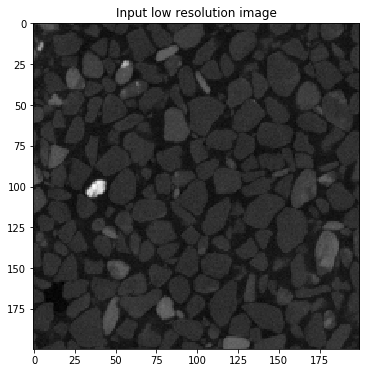

In [83]:
labda       = 0.2   # sparsity regularization
overlap     = 4     # the more overlap the better (patch size 5x5)
upscale     = 2     # scaling factor, depending on the trained dictionary
max_iters   = 20    # if 0, do not use backprojection
patch_size  = 5

low_resolution_img_path = '../images/low_resolution_img.tif'
low_resolution_img = tif.imread(low_resolution_img_path)
plt.figure(figsize=(6,6))
plt.imshow(low_resolution_img, plt.cm.gray)
plt.title('Input low resolution image')
plt.show()

## Image super-resolution based on sparse representation
<font size = "4"> We wrap everything in below function to use the model. Complete the function can deepen your understanding, includeing feature engineering and Lasso regression</font>

In [70]:
def lin_scale(hPatch, mNorm):
    """
    Scale the image contrast
    """
    hNorm = np.linalg.norm(hPatch)
    if hNorm > 0:
        scale = 1.2 * mNorm / hNorm
        hPatch = scale * hPatch
    return hPatch

def img_super_resolution(low_resolution_img, upscale, D_high, D_low, labda, overlap):
    # normalize the dictionary
    D_high = D_high/np.sqrt(np.sum(D_high**2, axis=0))
    D_low  = D_low/np.sqrt(np.sum(D_low**2, axis=0))

    # get patch_size
    patch_size = int(np.sqrt(D_high.shape[0]))

    # bicubic interpolation of the low_resolution_img
    m, n = low_resolution_img.shape
    # The first step is to make sure the low_resolution_img has the same size as high_resolution img
    medium_resolution_img = cv2.resize(low_resolution_img, \
        (m*upscale, n*upscale), interpolation=cv2.INTER_CUBIC)
    M, N = medium_resolution_img.shape

    # initialize high_resolution_img
    high_resolution_img = np.zeros(medium_resolution_img.shape)
    count_map = np.zeros(medium_resolution_img.shape)

    # extract low_resolution_img features
    row, col = medium_resolution_img.shape
    features = np.zeros((row,col,4))
    
    # first order gradient filters
    hf1 = np.array([-1,0,1]).reshape(1,-1)
    vf1 = hf1.T
    # second order gradient filters
    hf2 = np.array([1,0,-2,0,1]).reshape(1,-1)
    vf2 = hf2.T
    
    ###### TODO: part(j) ######
    # get low_resolution_img features using four Kernels above through convolution#
    features[:,:,0] = signal.convolve2d(medium_resolution_img, hf1, 'same')
    features[:,:,1] = signal.convolve2d(medium_resolution_img, vf1, 'same')
    features[:,:,2] = signal.convolve2d(medium_resolution_img, hf2, 'same')
    features[:,:,3] = signal.convolve2d(medium_resolution_img, vf2, 'same')
    ###### TODO: part(j) ######

    # patch index for sparse recovery, avoid boundary
    p = patch_size//2
    gridx = np.array(list(range(p,M-patch_size-p,patch_size-overlap))+[M-patch_size-p])
    gridy = np.array(list(range(p,N-patch_size-p,patch_size-overlap))+[N-patch_size-p])
    
    A = D_low.T @ D_low

    # loop to recover each high resolution patch
    for i in np.arange(len(gridx)):
        for j in np.arange(len(gridx)):
            patch_idx = i*len(gridy)+j
            xx = gridx[i]
            yy = gridy[j]

            # column feature
            mPatch = medium_resolution_img[xx:xx+patch_size, yy:yy+patch_size].reshape(-1)
            mMean  = np.mean(mPatch)
            mPatch = mPatch - mMean
            mNorm  = np.linalg.norm(mPatch)

            mPatchFea = features[xx:xx+patch_size, yy:yy+patch_size, :].reshape(-1)
            mPatchFea = mPatchFea - np.mean(mPatchFea)
            mFeaNorm  = np.linalg.norm(mPatchFea)

            y = mPatchFea / mNorm if mFeaNorm > 1 else mPatchFea
            b = -D_low.T @ y
            
            ###### TODO: part(k) ######
            # solve for sparce coefficient using feature sign w
            w = L1_FeatureSign(labda, A, b)
            ###### TODO: part(k) ######

            ###### TODO: part(k) ######
            # recover high resolution patch hPatch
            hPatch = D_high @ w
            ###### TODO: part(k) ######
            hPatch = lin_scale(hPatch, mNorm)
            hPatch = hPatch.reshape(patch_size, patch_size)
            hPatch = hPatch + mMean

            high_resolution_img[xx:xx+patch_size, yy:yy+patch_size] += hPatch
            count_map[xx:xx+patch_size, yy:yy+patch_size] += 1

    # fill in the empty with bicubic interpolation
    high_resolution_img[count_map < 1] = medium_resolution_img[count_map < 1]
    count_map[count_map < 1] = 1
    high_resolution_img = high_resolution_img / count_map
    high_resolution_img = normalize_image(high_resolution_img, 256)

    return high_resolution_img

In [75]:
high_resolution_img = img_super_resolution(low_resolution_img, upscale, D_high, D_low, labda, 4)

## Enhance Results Through Backprojection
<font size = "4"> We can futrher better the performance via a backprojection step, this is very common in image processing practice. The core idea is to learn the difference between learned high resolution image and input low resolution one, in another word, to learn the residual. Keep adding the difference on the high resolution image will slightly further improve the performance. </font>

In [77]:
def gaussian_kernel(size, sigma=None):
    if sigma == None:
        sigma = size // 6
    center = size // 2
    kernel = np.zeros((size, size))
    for i in np.arange(size):
        for j in np.arange(size):
            diff2 = (i-center)**2 + (j-center)**2
            kernel[i,j] = np.exp(-diff2/sigma**2/2)
    return kernel/np.sum(kernel)

def backprojection(high_resolution_img, low_resolution_img, max_iters):
    row_h, col_h = high_resolution_img.shape
    row_l, col_l = low_resolution_img.shape
    p = gaussian_kernel(5,1)
    p = p**2
    p = p/np.sum(p)

    high_resolution_img = high_resolution_img.astype(float)
    low_resolution_img  = low_resolution_img.astype(float)

    for i in np.arange(max_iters):
        temp = cv2.resize(high_resolution_img, (row_l, col_l), interpolation=cv2.INTER_CUBIC)
        image_diff = low_resolution_img - temp
    
        image_diff = cv2.resize(image_diff, (row_h, col_h), interpolation=cv2.INTER_CUBIC)
        high_resolution_img = high_resolution_img + signal.convolve2d(image_diff, p, 'same')
    return high_resolution_img

In [78]:
high_resolution_img_bp = backprojection(high_resolution_img, low_resolution_img, max_iters)

# Part 4: Result Visualization
<font size = "4"> You should get excited to visualize the result now. You may find that the learned result is always identical to the ground truth. This actually proved that our method works pretty good. We tend to emphasize that as more and more image processing jobs are done with neural network. Conventional method still thrive and we personally are more fascinated by this method. It has closer connection to theory and more tractable. </font>

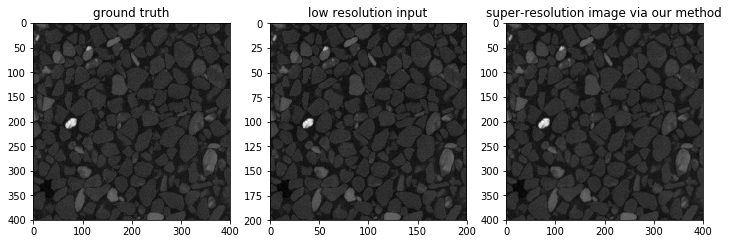

In [80]:
high_resolution_img_path = '../images/high_resolution_img.tif'
high_resolution_img_gt = tif.imread(high_resolution_img_path)
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(high_resolution_img_gt, plt.cm.gray)
plt.title('ground truth')
plt.subplot(1,3,2)
plt.imshow(low_resolution_img, plt.cm.gray)
plt.title('low resolution input')
plt.subplot(1,3,3)
plt.imshow(high_resolution_img_bp, plt.cm.gray)
plt.title('super-resolution image via our method')
plt.show()

<font size = "4"> We zoomed in to better visualize the result, the area we chose is around the white spot at left middle part. We saved the result in the folder *images*.</font>

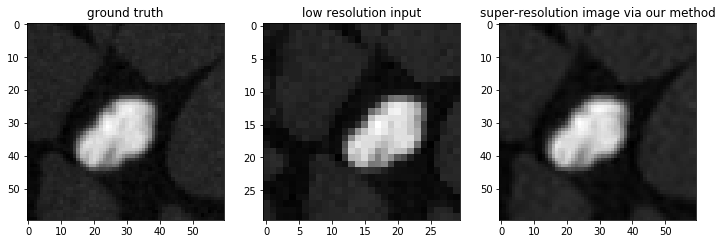

In [81]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(high_resolution_img_gt[170:230,50:110], plt.cm.gray)
plt.title('ground truth')
plt.subplot(1,3,2)
plt.imshow(low_resolution_img[85:115,20:50], plt.cm.gray)
plt.title('low resolution input')
plt.subplot(1,3,3)
plt.imshow(high_resolution_img_bp[170:230,50:110], plt.cm.gray)
plt.title('super-resolution image via our method')
plt.show()

## Reference:
<font size = "4">Yang, J., Wright, J., Huang, T. S., & Ma, Y. (2010). Image super- resolution via sparse representation. IEEE transactions on image pro- cessing, 19(11), 2861-2873.

Lee, H., Battle, A., Raina, R., & Ng, A. Y. (2007). Efficient sparse coding algorithms. In Advances in neural information processing systems (pp. 801-808). </font>